## Import Packages

In [1]:
import os
import yaml
import math
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.io
import humanfriendly

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

## Parameters

In [3]:
# this cell is tagged `parameters` and will be overridden by papermill
sample_name = "1973_HD1915_7xNK_FB_HTO"
path_h5ad = "/test/hashtag/1973_HD1915_7xNK_FB_HTO.h5ad"
path_report = "/test/hashtag/run_report.yaml"
path_reads = "/test/hashtag/reads"
path_outdir = "/test/hashtag"

In [5]:
import os
os.getcwd()

'/Users/krauset/projects/sharp_dev/dockers/basic-qc/notebooks'

## Run Report

In [7]:
!cat $path_report

Date: 2024-09-26
Running time: 4.0 minutes, 25.71 seconds
CITE-seq-Count Version: 1.4.3
Reads processed: 2500000
Percentage mapped: 8
Percentage unmapped: 92
Uncorrected cells: 1
Correction:
	Cell barcodes collapsing threshold: 1
	Cell barcodes corrected: 24635
	UMI collapsing threshold: 1
	UMIs corrected: 20416
Run parameters:
	Read1_filename: /cromwell-executions/Hashtag/abaec972-39cc-4529-a0a6-2744d5abee60/call-Preprocess/Preprocess/e0583ab8-af50-4af8-831d-bc17ae7ea478/call-CiteSeqCount/inputs/1256543558/R1.fastq.gz
	Read2_filename: /cromwell-executions/Hashtag/abaec972-39cc-4529-a0a6-2744d5abee60/call-Preprocess/Preprocess/e0583ab8-af50-4af8-831d-bc17ae7ea478/call-CiteSeqCount/inputs/-540407801/R2.fastq.gz
	Cell barcode:
		First position: 1
		Last position: 16
	UMI barcode:
		First position: 17
		Last position: 26
	Expected cells: 0
	Tags max errors: 2
	Start trim: 10


In [8]:
with open(path_report, "rt") as fin:
    # report file contains tabs
    # run_report = yaml.load(fin, Loader=yaml.FullLoader)
    run_report = fin.read().replace("\t", "  ")
    run_report = yaml.load(run_report, Loader=yaml.FullLoader)

In [9]:
# num of reads processed
humanfriendly.format_number(run_report["Reads processed"])

'2,500,000'

In [10]:
# percentage mapped
run_report["Percentage mapped"]

8

## Load AnnData

In [38]:
adata = sc.read_h5ad(path_h5ad)
adata

AnnData object with n_obs × n_vars = 23026 × 3
    obs: 'unmapped', 'barcode_sequence', 'hashID', 'Doublet_Info'
    var: 'feature_name'
    uns: 'metrics'
    layers: 'dsb_normalized'

## Load Read Counts

In [39]:
# read mtx
barcodes = pd.read_csv(os.path.join(path_reads, "barcodes.tsv.gz"), header=None, index_col=0, sep="\t")
features = pd.read_csv(os.path.join(path_reads, "features.tsv.gz"), header=None, index_col=0, sep="\t")
mtx = scipy.io.mmread(os.path.join(path_reads, "matrix.mtx.gz"))

# subset
subset = barcodes.index.isin(adata.obs_names)
mtx_filtered = mtx.T.tocsr()[subset].toarray()

# add info
adata.layers["reads"] = mtx_filtered[:, :-1]
adata.obs["unmapped_reads"] = mtx_filtered[:, -1]


### Results

In [40]:
df_stats = adata.obs.groupby("hashID", observed=False).size()

In [41]:
print("--- .X ---")
display(adata.to_df().head())

print("--- .obs ---")
display(adata.obs.head())

print("--- counts ---")
display(df_stats)

print("--- doublets ---")
display(adata.obs.groupby("Doublet_Info", observed=False).size())

--- .X ---


,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CTCATTAGTTCCACAA,18,0,0
CTGCTGTGTTGTACAC,0,2,0
GTATCTTTCCTCATTA,0,0,0
GTTCATTTCCTCAACC,1,0,0
GTAACGTGTCTAAAGA,1,0,0


--- .obs ---


,unmapped,barcode_sequence,hashID,Doublet_Info,unmapped_reads
CTCATTAGTTCCACAA,10,CTCATTAGTTCCACAA,CC0301-ACCCACCAGTAAGAC,NaN,85
CTGCTGTGTTGTACAC,13,CTGCTGTGTTGTACAC,Negative,NaN,8
GTATCTTTCCTCATTA,54,GTATCTTTCCTCATTA,Negative,NaN,49
GTTCATTTCCTCAACC,41,GTTCATTTCCTCAACC,Negative,NaN,49
GTAACGTGTCTAAAGA,96,GTAACGTGTCTAAAGA,Negative,NaN,72


--- counts ---


hashID
C0302-GGTCGAGAGCATTCA       951
C0303-CTTGCCGCATGTCAT       873
CC0301-ACCCACCAGTAAGAC      925
Doublet                      64
Negative                  20213
dtype: int64

--- doublets ---


Doublet_Info
C0302-GGTCGAGAGCATTCA, C0303-CTTGCCGCATGTCAT     25
CC0301-ACCCACCAGTAAGAC, C0302-GGTCGAGAGCATTCA    18
CC0301-ACCCACCAGTAAGAC, C0303-CTTGCCGCATGTCAT    21
dtype: int64

### Pie Chart

In [42]:
labels = [label if label != "Doublet" else "Doublet/Negative" for label in df_stats.index]
labels

['C0302-GGTCGAGAGCATTCA',
 'C0303-CTTGCCGCATGTCAT',
 'CC0301-ACCCACCAGTAAGAC',
 'Doublet/Negative',
 'Negative']

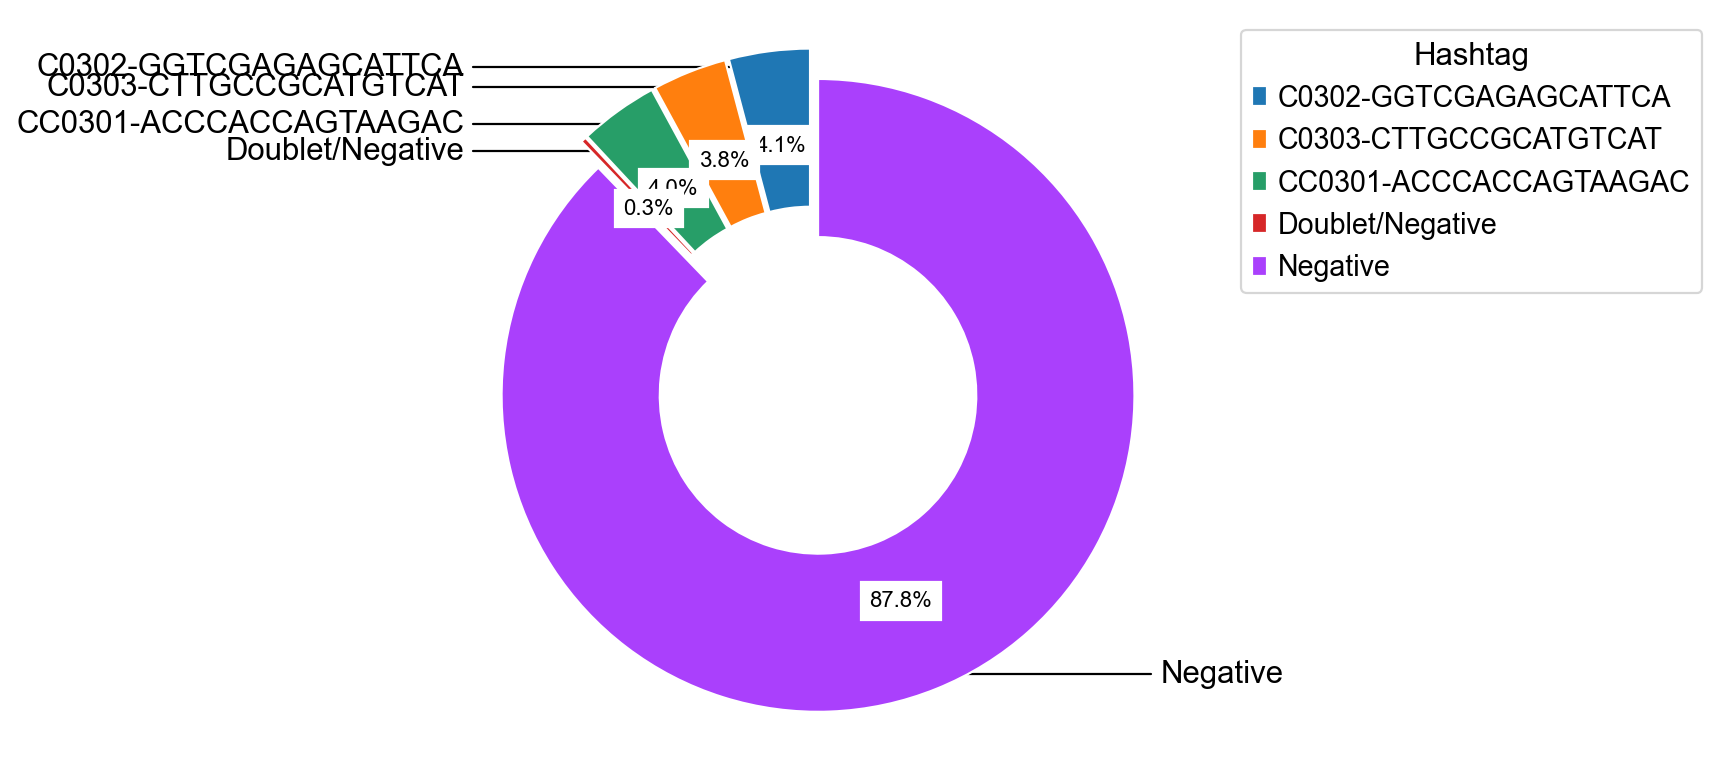

In [43]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

cmap = plt.get_cmap("tab20c")

wedges, _, autotexts = ax.pie(
    df_stats,
    explode=[0.05] * len(df_stats),
    wedgeprops=dict(width=0.5, edgecolor='w'),
    autopct='%1.1f%%',
    pctdistance=0.7,
    shadow=False,
    startangle=90,
    rotatelabels=True
)

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        labels[i], xy=(x, y), xytext=(1.1 * np.sign(x), y),
        horizontalalignment=horizontalalignment, **kw
    )

for i, autotext in enumerate(autotexts):
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_rotation(0)
    autotext.set_backgroundcolor("white")

ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    bbox_to_anchor=(1.2, 0.0, 0.5, 1)
)

plt.show()

### Distribution

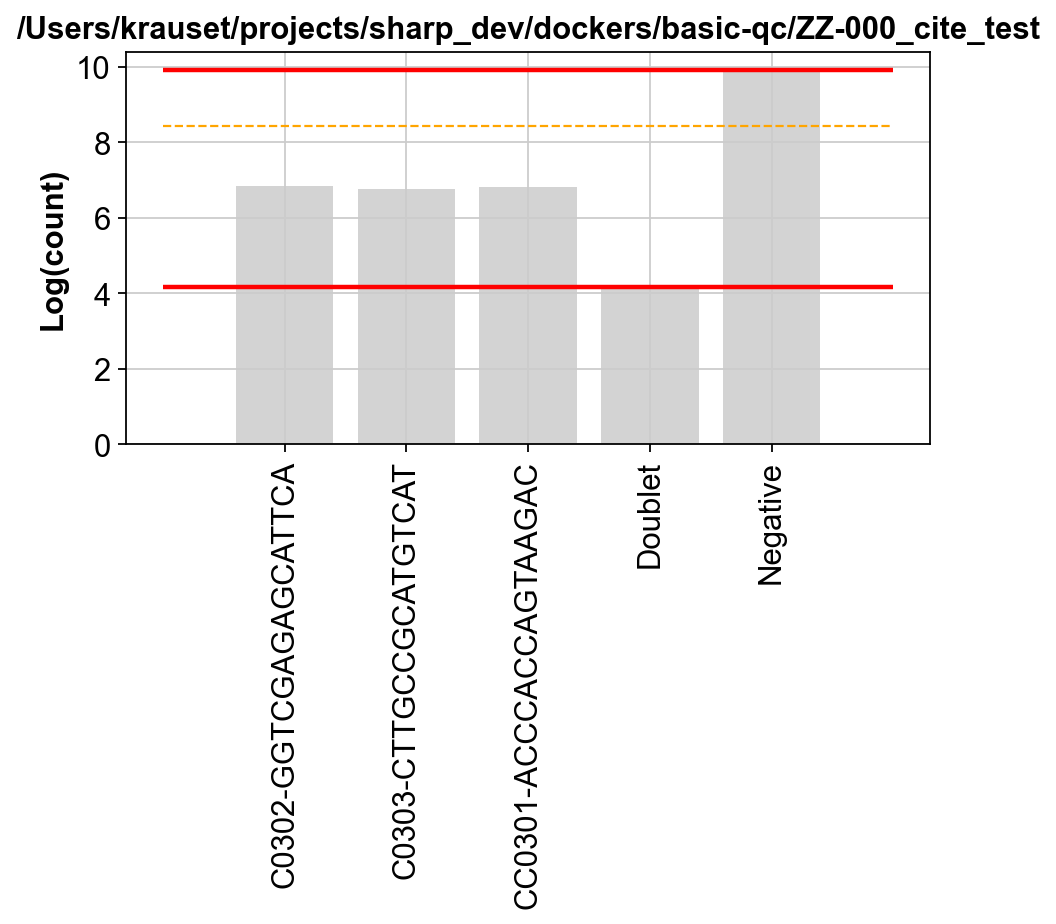

In [44]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.bar(df_stats.index, np.log(list(df_stats.values)), color="lightgray")

ax.set_ylabel("Log(count)", fontweight="bold")
ax.set_title(sample_name, fontsize=14, fontweight="heavy")
ax.tick_params(axis="x", rotation=90)

if len(df_stats) != 0:
    num_hashtags = len(df_stats.values)
    ax.hlines(y=np.log(max(df_stats.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)
    ax.hlines(y=np.log(min(df_stats.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)
    ax.hlines(y=np.log(np.mean(list(df_stats.values))), xmin=-1, xmax=num_hashtags, colors='orange', linestyles='--', lw=1)

plt.tight_layout()

plt.show()

## Read Counts

In [46]:
adata.to_df(layer="reads")

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CTCATTAGTTCCACAA,1,2,0
CTGCTGTGTTGTACAC,0,38,0
GTATCTTTCCTCATTA,0,0,0
GTTCATTTCCTCAACC,0,0,0
GTAACGTGTCTAAAGA,0,69,0
...,...,...,...
TGTTCCGTCCTTGGTC,0,0,0
TGGGAAGTCCAGAGGA,0,0,0
CCACGGACAATACGCT,0,3,0
AAGTCTGCAGGTCTCG,0,0,8


### Matrix vs. Run Report

Note that unmapped reads are excluded.

In [55]:
reads_cell = adata.layers["reads"].sum()
reads_total = run_report["Reads processed"]
print("Reads in cells", f"{adata.layers["reads"].sum() / 1e6:.2f}M ({reads_cell / reads_total * 100:.1f}%)")
print("Reads total", f"{run_report["Reads processed"]/1e6:.2f}M")

Reads in cells 0.11M (4.4%)
Reads total 2.50M


### Total Reads per Hashtag

In [58]:
adata.var["total_reads"] = adata.layers["reads"].sum(axis=0)
adata.var["total_reads"]

CC0301-ACCCACCAGTAAGAC    32841
C0302-GGTCGAGAGCATTCA     58459
C0303-CTTGCCGCATGTCAT     19785
Name: total_reads, dtype: int64

### Total Reads per Celluar Barcode

In [60]:
adata.obs["total_reads"] = adata.layers["reads"].sum(axis=1)
adata.obs["total_reads"]

CTCATTAGTTCCACAA     3
CTGCTGTGTTGTACAC    38
GTATCTTTCCTCATTA     0
GTTCATTTCCTCAACC     0
GTAACGTGTCTAAAGA    69
                    ..
TGTTCCGTCCTTGGTC     0
TGGGAAGTCCAGAGGA     0
CCACGGACAATACGCT     3
AAGTCTGCAGGTCTCG     8
TTCGGTCAGTGCCATT     0
Name: total_reads, Length: 23026, dtype: int64

### Zero Rows

In [63]:
print(f"Non Zero Reads: {np.count_nonzero(adata.obs["total_reads"] == 0)}")
print(f"Non Zero Fraction: {np.count_nonzero(adata.obs["total_reads"] == 0) / adata.shape[0] * 100:.1f}%")


Non Zero Reads: 9096
Non Zero Fraction: 39.5%


### First Hashtag

In [65]:
# define a variable called "hashtags" contains all the hashtag names except "Doublet" and "Negative"
hashtags = sorted(list(set(adata.obs["hashID"].unique()) - set(["Doublet", "Negative"])))
hashtags

['C0302-GGTCGAGAGCATTCA', 'C0303-CTTGCCGCATGTCAT', 'CC0301-ACCCACCAGTAAGAC']

In [66]:
# pick the first hashtag
first_hashtag = hashtags[0] if len(hashtags) > 0 else None
first_hashtag

'C0302-GGTCGAGAGCATTCA'

In [68]:
adata.to_df(layer="reads")[adata.obs["hashID"] == first_hashtag].sort_values(adata.var.index[0], ascending=False)

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
GGACAGAAGAGTTGGC,109,1,0
ACCAGTACACCATCCT,70,0,0
ACCCACTTCGACCAGC,54,2,0
TCACGAATCACAAACC,51,0,0
TTCTTAGGTCCGAACC,48,0,0
...,...,...,...
TCAACGAGTCGCCATG,0,1,1
CGCCAAGAGTCGAGTG,0,0,0
CCTCAGTCAAACTGCT,0,0,0
AGCGTATTCAAGAAGT,0,54,0


### Overall Stats

In [69]:
adata.to_df(layer="reads").sum(axis=1).describe()

count    23026.000000
mean         4.824329
std         13.950828
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        628.000000
dtype: float64

### 95 Percentile

In [70]:
percentile_95 = adata.obs["total_reads"].describe(percentiles=[0.95])["95%"]
percentile_95

np.float64(28.0)

In [71]:
adata.to_df(layer="reads")[ adata.obs["total_reads"] > percentile_95 ]

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CTGCTGTGTTGTACAC,0,38,0
GTAACGTGTCTAAAGA,0,69,0
GGCTCGATCTTCGAGA,1,1,41
CTGTTTATCTATCGCC,0,14,17
CTCGAAATCCTTTACA,0,88,0
...,...,...,...
ACGCAGCGTATGAATG,35,2,0
TTTACTGAGTCTCAAC,0,74,0
GACTACAGTTGTACAC,28,0,1
AGGCCGTTCGAATGGG,0,89,1


In [72]:
adata.to_df(layer="reads")[ adata.obs["total_reads"] > percentile_95 ].sample(5, random_state=0)

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
TCTCATACAGGCGATA,0,40,1
GAGTCCGTCATGCTCC,0,49,0
CTTAACTCACGGATAG,0,104,1
GCGCAACTCGTACCGG,1,37,0
ACAGCTAGTGGTGTAG,27,1,1


In [73]:
adata.to_df(layer="reads")[ adata.obs["total_reads"] > percentile_95 ].sample(5, random_state=0).sum(axis=1)

TCTCATACAGGCGATA     41
GAGTCCGTCATGCTCC     49
CTTAACTCACGGATAG    105
GCGCAACTCGTACCGG     38
ACAGCTAGTGGTGTAG     29
dtype: int64

### Histogram (sum of reads across hashtags)

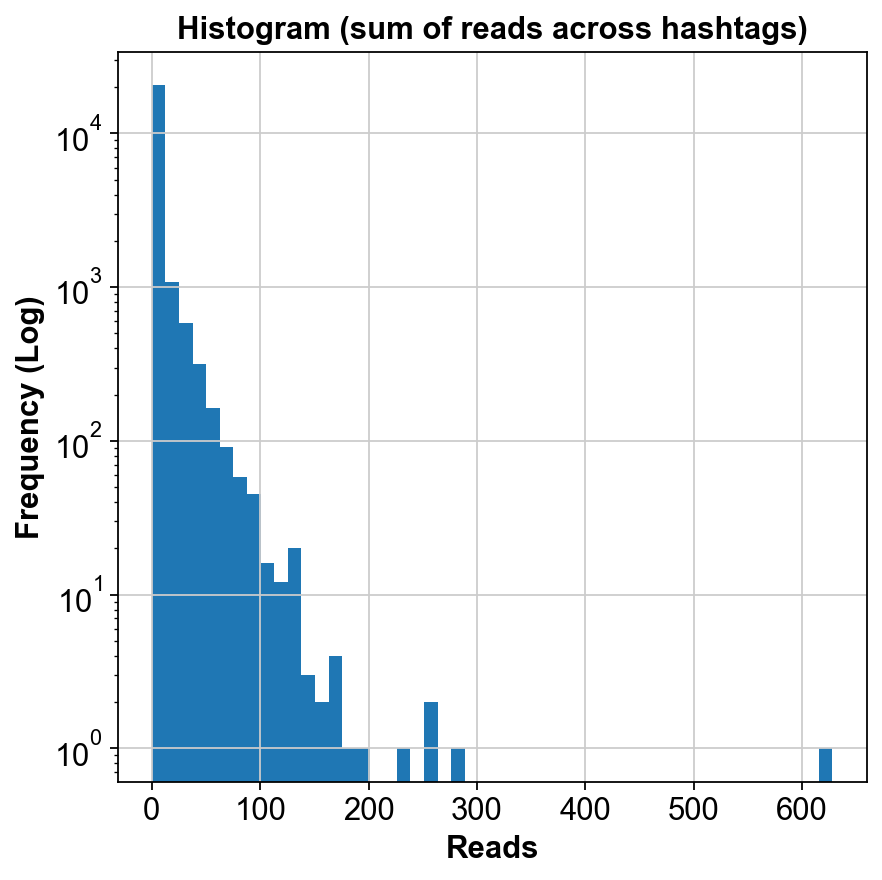

In [75]:
fig, ax = plt.subplots(figsize=(6,6), facecolor="white")

ax.hist(adata.obs["total_reads"].sort_values(ascending=False), bins=50)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.set_title("Histogram (sum of reads across hashtags)", fontweight="bold")

plt.yscale("log")
plt.show()

### Histogram (sum of reads per hashtag)

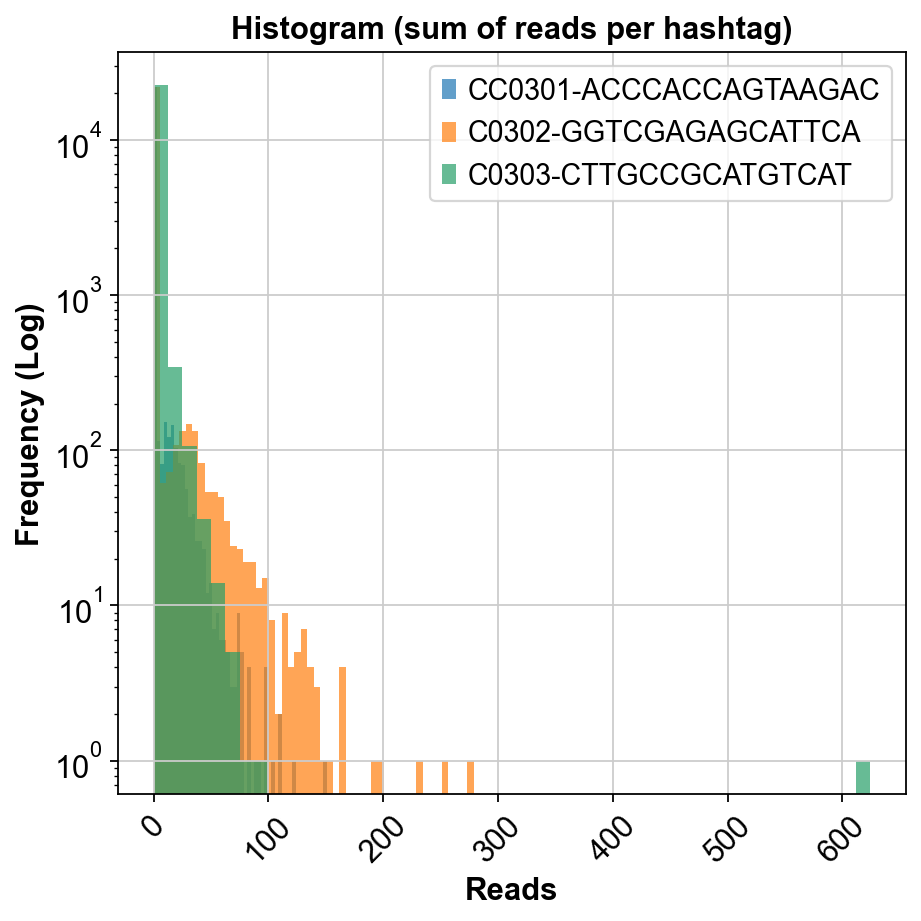

In [78]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

for idx, col in enumerate(adata.var_names):

    df_tmp = np.sort(adata.layers["reads"][:, idx])[::-1]

    ax.hist(df_tmp, bins=50, alpha=0.7, label=col)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.set_title("Histogram (sum of reads per hashtag)", fontweight="bold")
ax.legend()

plt.yscale("log")
plt.tight_layout()
plt.show()

### Unmapped

In [79]:
adata.obs["unmapped_reads"].sort_values(ascending=False)

CGGACGTAGTATCTCG    13875
ACGCAGCCAGACAGGT    10245
CGTTCTGTCCCAGGTG     9883
AGATCTGGTCCAACTA     7990
CGTTGGGCACATCCAA     6498
                    ...  
ATTCTACAGGGCTCTC        0
AAGGTTCAGTGAACAT        0
ACTGTCCTCAGGCCCA        0
GGCGACTAGCACGCCT        0
GGAGCAATCGGCTTGG        0
Name: unmapped_reads, Length: 23026, dtype: int64

In [80]:
adata.obs["unmapped_reads"].sum()

np.int64(1360437)

### Total vs. Unmapped Reads

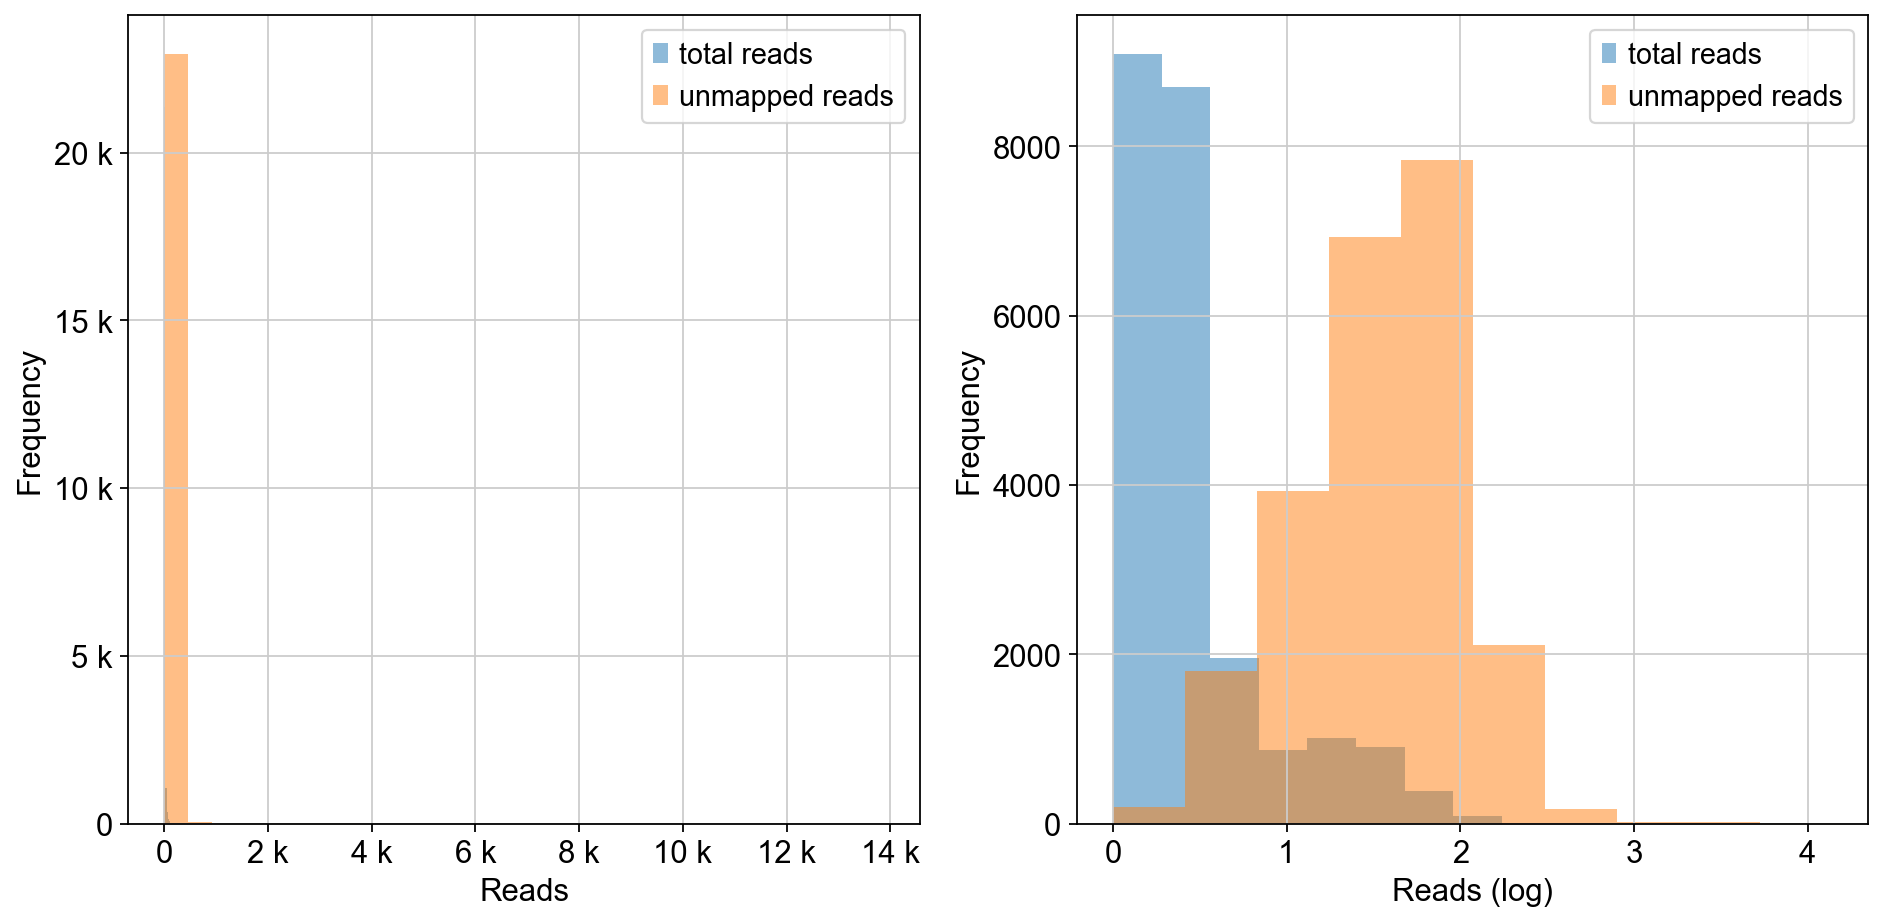

In [82]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), facecolor="white")
ax = np.ravel(ax)

ax[0].hist(adata.obs["total_reads"], bins=30, label="total reads", alpha=0.5)
ax[0].hist(adata.obs["unmapped_reads"], bins=30, label="unmapped reads", alpha=0.5)

ax[0].set_xlabel("Reads")
ax[0].set_ylabel("Frequency")
ax[0].xaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax[0].yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax[0].legend()

ax[1].hist(np.log10(adata.obs["total_reads"] + 1), label="total reads", alpha=0.5)
ax[1].hist(np.log10(adata.obs["unmapped_reads"] + 1), label="unmapped reads", alpha=0.5)

ax[1].set_xlabel("Reads (log)")
ax[1].set_ylabel("Frequency")
ax[1].legend()

plt.tight_layout()
plt.show()

## UMI Counts

In [85]:
# total UMIs per cell barcode
adata.obs["total_umis"] = adata.X.sum(axis=1)

### Histogram (sum of UMIs across hashtag)

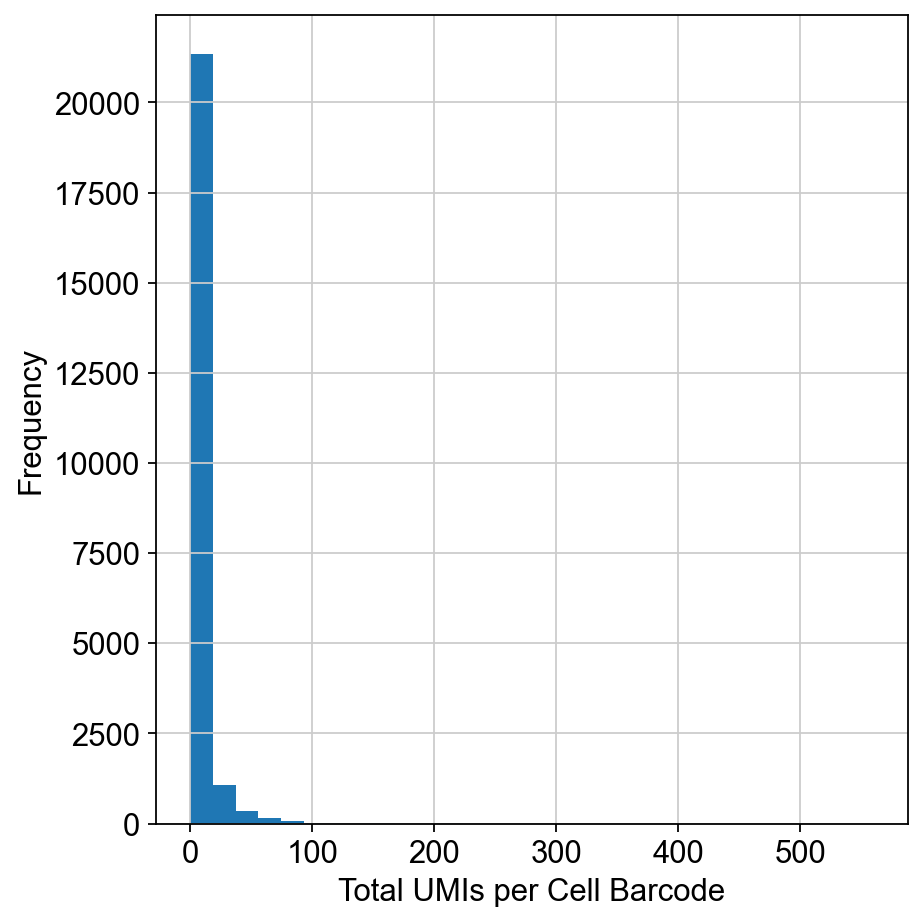

In [87]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

ax.hist(adata.obs["total_umis"], bins=30)
ax.set_xlabel("Total UMIs per Cell Barcode")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [88]:
adata.to_df().describe()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
count,23026.000000,23026.000000,23026.000000
mean,1.291279,2.291974,0.773387
std,5.599354,10.061056,5.142307
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,133.000000,254.000000,557.000000


## Reads per UMI

### Calculate

In [91]:
# reads divided by UMI, replace NaN with zero
reads_per_umi = np.nan_to_num(adata.layers["reads"] / adata.X.toarray())

/var/folders/cr/tgfzhd3x5cq846swrbb6hh25l39xvy/T/ipykernel_79229/21376912.py:2: RuntimeWarning: divide by zero encountered in divide
  reads_per_umi = np.nan_to_num(adata.layers["reads"] / adata.X.toarray())
/var/folders/cr/tgfzhd3x5cq846swrbb6hh25l39xvy/T/ipykernel_79229/21376912.py:2: RuntimeWarning: invalid value encountered in divide
  reads_per_umi = np.nan_to_num(adata.layers["reads"] / adata.X.toarray())


In [92]:
pd.DataFrame(reads_per_umi)

,0,1,2
0,0.055556,1.797693e+308,0.0
1,0.000000,1.900000e+01,0.0
2,0.000000,0.000000e+00,0.0
3,0.000000,0.000000e+00,0.0
4,0.000000,1.797693e+308,0.0
...,...,...,...
23021,0.000000,0.000000e+00,0.0
23022,0.000000,0.000000e+00,0.0
23023,0.000000,1.797693e+308,0.0
23024,0.000000,0.000000e+00,1.0


In [93]:
adata.obs["total_umis"].sum()

np.int64(100316)

In [94]:
adata.obs["total_reads"].sum()

np.int64(111085)

In [95]:
avg_reads_per_umi= adata.obs["total_reads"].sum() / adata.obs["total_umis"].sum()
avg_reads_per_umi

np.float64(1.1073507715618645)

### Histogram

In [100]:
avg_reads_per_umi

np.float64(1.1073507715618645)

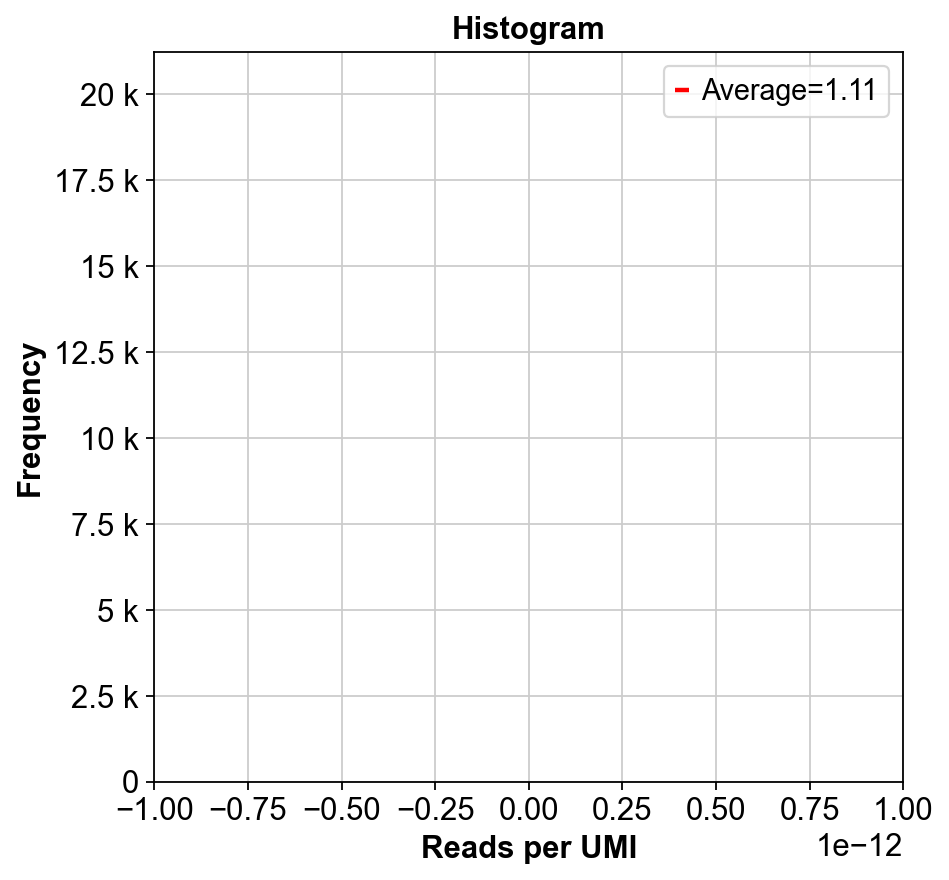

In [103]:
fig, ax = plt.subplots(figsize=(6,6), facecolor="white")

n, bins, _ = ax.hist(reads_per_umi, bins=50, color=["lightgray", "lightgray", "lightgray"])
ax.vlines(
    x=avg_reads_per_umi,
    ymin=0, ymax=np.max(n),
    color="red", linestyle="--", lw=2,
    label=f"Average={avg_reads_per_umi:.2f}"
)

ax.set_xlabel("Reads per UMI", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.set_title("Histogram", fontweight="bold")
ax.legend()

plt.show()

## UMI (one vs. rest)

- Ideally, the winning one shouldn't be winning by having less than e.g. 10 UMIs?
- Ideally, the losing ones should have UMIs close to zero.

### All

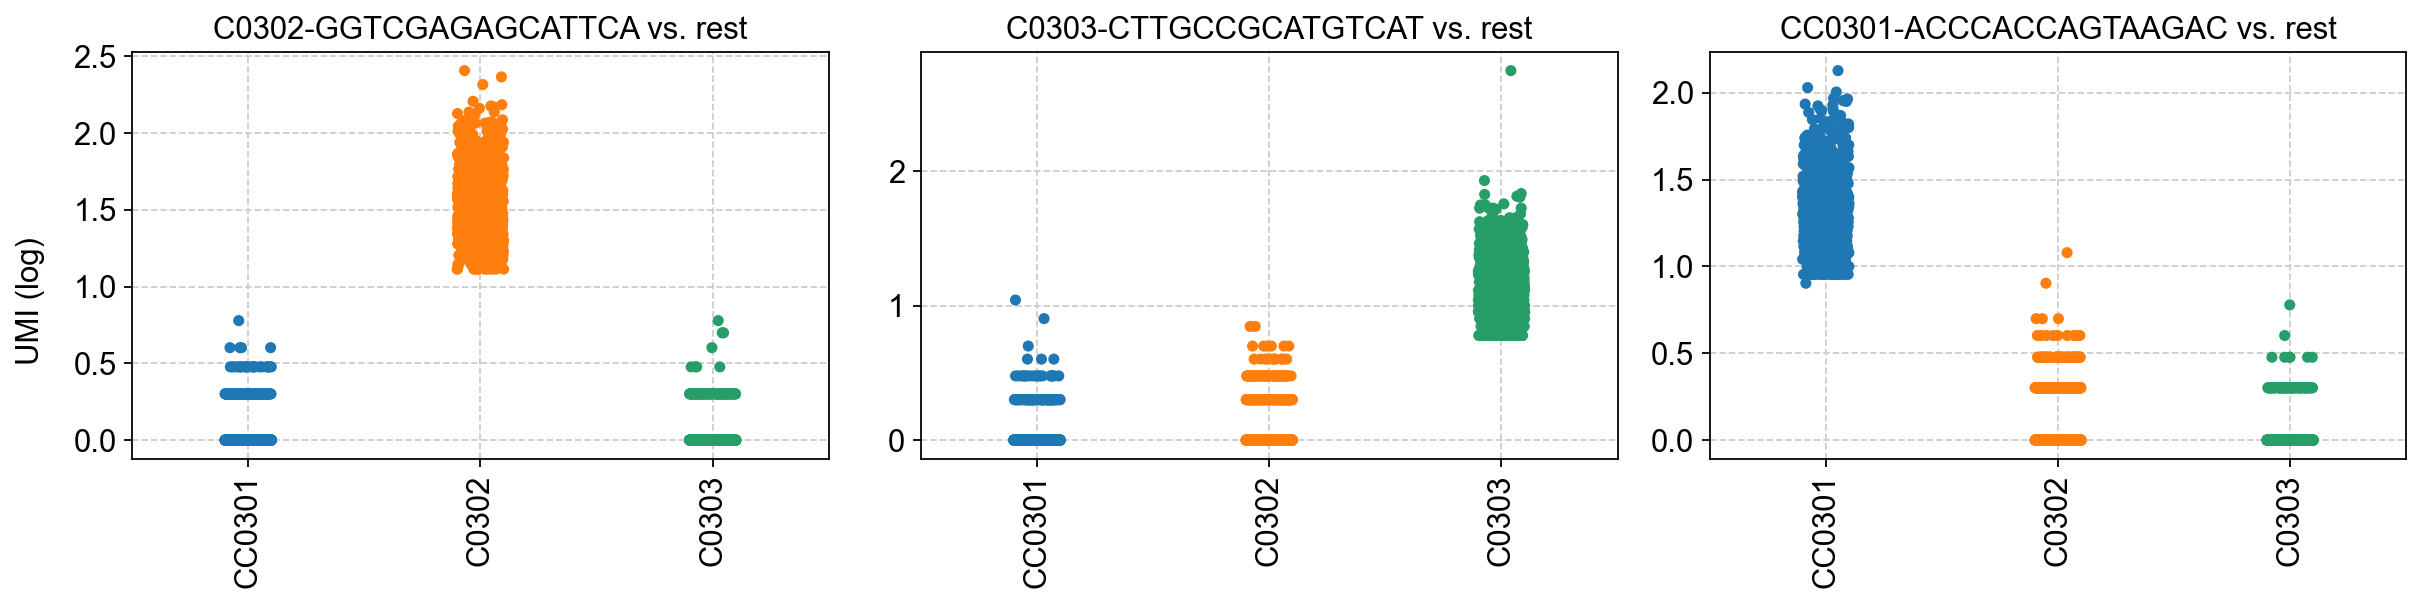

In [107]:
num_hashtags = len(adata.var_names)
num_cols = 3
num_rows = math.ceil(num_hashtags / num_cols)

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, num_rows * 4), facecolor="white")
axes = np.ravel(axes)

for idx, hashtag in enumerate(sorted(hashtags)):

    ax = axes[idx]

    df_tmp = adata[adata.obs["hashID"] == hashtag].to_df()
    df_tmp.columns = df_tmp.columns.str.split("-").str[0]

    sns.stripplot(data=np.log10(df_tmp + 1), ax=ax)

    ax.set_title(f"{hashtag} vs. rest")
    ax.grid(linestyle="--")
    ax.tick_params(axis="x", rotation=90)


fig.text(-0.01, 0.5, "UMI (log)", va='center', rotation='vertical')
plt.tight_layout()
plt.show()

### 25th Percentile

In [108]:
umi_sum_percentile_25 = adata.obs["total_umis"].describe()["25%"]
umi_sum_percentile_25

np.float64(0.0)

In [109]:
adata[ (adata.obs["total_umis"] < umi_sum_percentile_25) & (adata.obs["hashID"] != "Doublet") ].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT


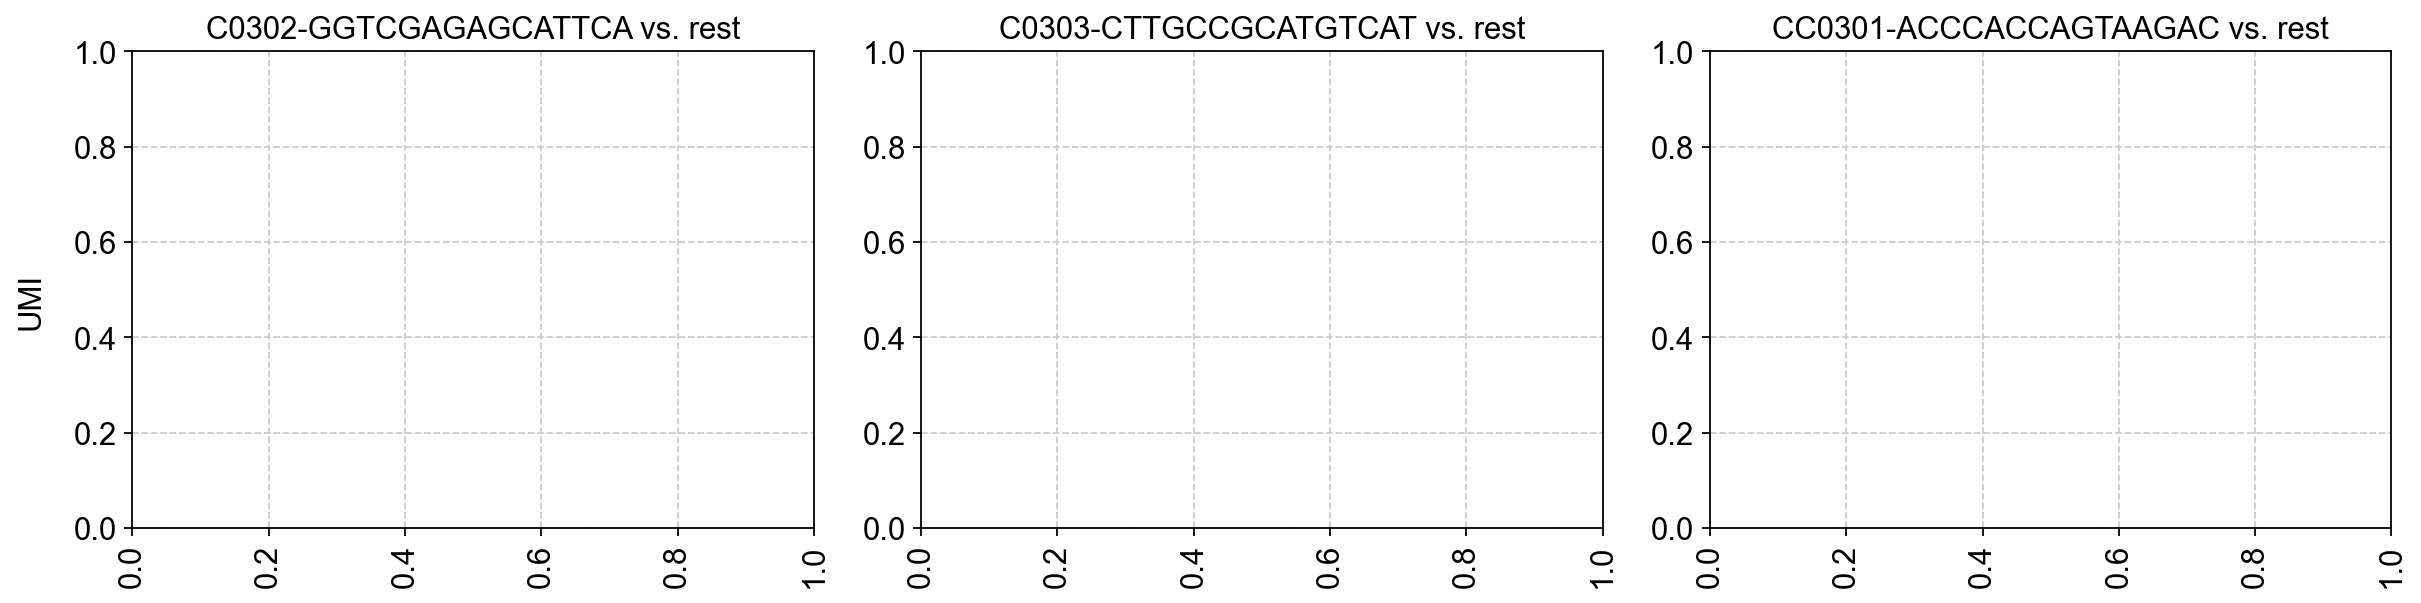

In [111]:
num_hashtags = len(adata.var_names)
num_cols = 3
num_rows = math.ceil(num_hashtags / num_cols)

fig, axes = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, num_rows * 4), facecolor="white")
axes = np.ravel(axes)

for idx, hashtag in enumerate(sorted(hashtags)):

    ax = axes[idx]

    df_tmp = adata[ (adata.obs["total_umis"] < umi_sum_percentile_25) & (adata.obs["hashID"] == hashtag) ].to_df()
    df_tmp.columns = df_tmp.columns.str.split("-").str[0]

    sns.stripplot(data=df_tmp, ax=ax)

    ax.set_title(f"{hashtag} vs. rest")
    ax.grid(linestyle="--")
    ax.tick_params(axis="x", rotation=90)

fig.text(-0.01, 0.5, "UMI", va='center', rotation='vertical')
plt.tight_layout()
plt.show()

## UMI Distribution

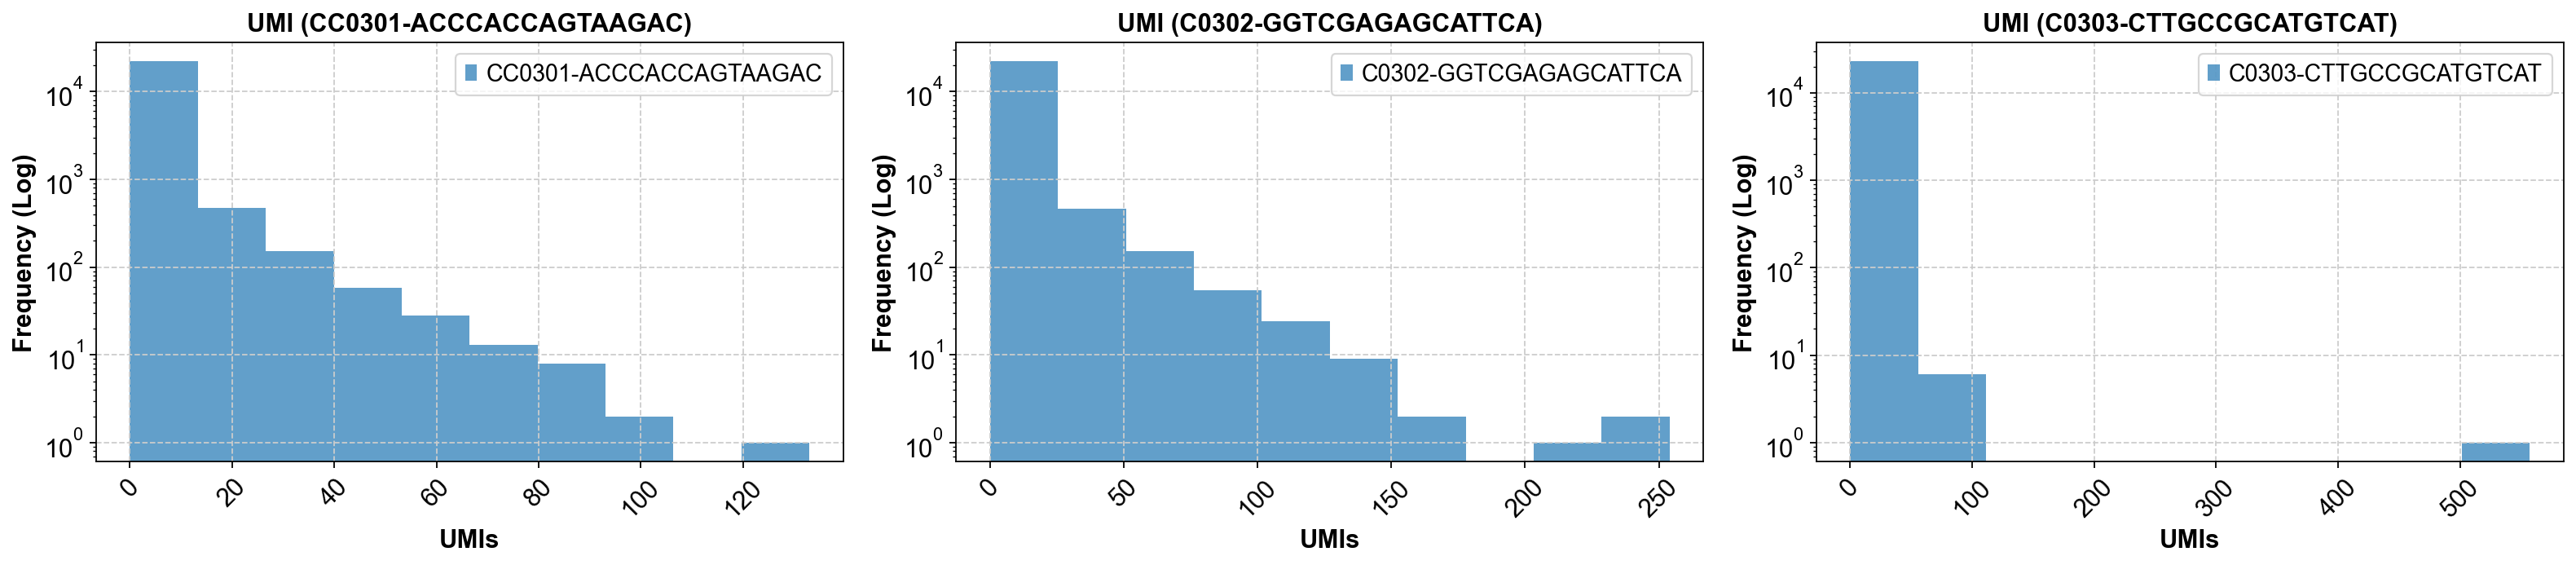

In [116]:
num_hashtags = len(adata.var_names)
num_cols = 3
num_rows = math.ceil(num_hashtags / num_cols + 1)

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for idx, col in enumerate(adata.var_names):

    idx_plot += 1
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)

    df_tmp = adata[:, idx].to_df().sort_values(by=adata.var_names[idx], ascending=False)

    ax.hist(df_tmp, bins=10, alpha=0.7, label=col)

    ax.set_xlabel("UMIs", fontweight="bold")
    ax.set_ylabel("Frequency (Log)", fontweight="bold")
    ax.tick_params(axis="x", rotation=45)
    ax.set_title(f"UMI ({col})", fontweight="bold")
    ax.grid(linestyle="--")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()
plt.show()

## Negative Check

In [117]:
# sort by total umi in descending order
adata_sorted = adata[adata.obs.sort_values(by="total_umis", ascending=False).index]

In [118]:
adata_sorted.to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CACAAACCACTATCTT,0,3,557
CCCTCCTAGTACGTTC,0,254,0
GCTGCAGCACGAGAGT,0,231,0
AGGCCACAGTTCGCGC,0,176,46
CACCAGGCACCAGTTA,1,206,0
...,...,...,...
GTGAAGGTCTTCAACT,0,0,0
TTTCCTCGTTTAGCTG,0,0,0
TTAACTCTCCTCAATT,0,0,0
CTGCCTACATGCATGT,0,0,0


### Zero Rows

In [119]:
adata_sorted[ adata_sorted.obs["total_umis"] == 0 ].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CGATCGGGTCAGCTAT,0,0,0
CGGACTGAGATAGTCA,0,0,0
TCACAAGCACGGTAAG,0,0,0
GGCCGATCAAGGACTG,0,0,0
TACACGAAGGTAAACT,0,0,0
...,...,...,...
GTGAAGGTCTTCAACT,0,0,0
TTTCCTCGTTTAGCTG,0,0,0
TTAACTCTCCTCAATT,0,0,0
CTGCCTACATGCATGT,0,0,0


In [120]:
adata_sorted[ adata_sorted.obs["total_umis"] == 0 ].shape

(9096, 3)

In [121]:
# percentage
np.count_nonzero(adata_sorted.obs["total_umis"] == 0) / adata_sorted.shape[0] * 100.0

39.50317032919309

### Singlets

In [122]:
mask_singlet = (adata_sorted.obs["hashID"] != "Doublet") & (adata_sorted.obs["hashID"] != "Negative")
mask_singlet

CACAAACCACTATCTT     True
CCCTCCTAGTACGTTC     True
GCTGCAGCACGAGAGT     True
AGGCCACAGTTCGCGC    False
CACCAGGCACCAGTTA     True
                    ...  
GTGAAGGTCTTCAACT    False
TTTCCTCGTTTAGCTG    False
TTAACTCTCCTCAATT    False
CTGCCTACATGCATGT    False
TTCGGTCAGTGCCATT    False
Name: hashID, Length: 23026, dtype: bool

In [123]:
adata_sorted[mask_singlet]

View of AnnData object with n_obs × n_vars = 2749 × 3
    obs: 'unmapped', 'barcode_sequence', 'hashID', 'Doublet_Info', 'unmapped_reads', 'total_reads', 'total_umis'
    var: 'feature_name', 'total_reads'
    uns: 'metrics'
    layers: 'dsb_normalized', 'reads'

In [124]:
adata_sorted[mask_singlet].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CACAAACCACTATCTT,0,3,557
CCCTCCTAGTACGTTC,0,254,0
GCTGCAGCACGAGAGT,0,231,0
CACCAGGCACCAGTTA,1,206,0
TGGACGCTCCGCGCAA,0,160,0
...,...,...,...
AATCCAGAGTCCGTAT,0,0,5
CCTACACGTGAGTATA,0,0,5
AGCAGCCCAAGTTCTG,0,0,5
TGCGTGGGTGTCTGAT,0,0,5


In [125]:
# singlet only, total_umis < 10
adata_sorted[mask_singlet & (adata_sorted.obs["total_umis"] < 10)].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
AGTGGGAAGCACCGCT,9,0,0
GCAAACTCAAGGGTCA,0,0,9
CAGCCGATCAAACAAG,0,0,9
ACGGAGAAGTGCGTGA,0,0,9
GGCGACTGTAGCGTGA,0,1,8
...,...,...,...
AATCCAGAGTCCGTAT,0,0,5
CCTACACGTGAGTATA,0,0,5
AGCAGCCCAAGTTCTG,0,0,5
TGCGTGGGTGTCTGAT,0,0,5


In [126]:
# singlet only, total_umis >= 10
adata_sorted[mask_singlet & (adata_sorted.obs["total_umis"] >= 10)].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
CACAAACCACTATCTT,0,3,557
CCCTCCTAGTACGTTC,0,254,0
GCTGCAGCACGAGAGT,0,231,0
CACCAGGCACCAGTTA,1,206,0
TGGACGCTCCGCGCAA,0,160,0
...,...,...,...
CTTGGCTAGTTTGCGT,0,0,10
CGGAGCTAGAACAACT,10,0,0
ACGGCCAAGAATCTCC,10,0,0
AGGGAGTGTGTGAATA,0,0,10


### Doublets

In [127]:
mask_doublet = adata_sorted.obs["hashID"] == "Doublet"
mask_doublet

CACAAACCACTATCTT    False
CCCTCCTAGTACGTTC    False
GCTGCAGCACGAGAGT    False
AGGCCACAGTTCGCGC     True
CACCAGGCACCAGTTA    False
                    ...  
GTGAAGGTCTTCAACT    False
TTTCCTCGTTTAGCTG    False
TTAACTCTCCTCAATT    False
CTGCCTACATGCATGT    False
TTCGGTCAGTGCCATT    False
Name: hashID, Length: 23026, dtype: bool

In [128]:
adata_sorted[mask_doublet].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
AGGCCACAGTTCGCGC,0,176,46
GATCGCGGTCTTGTCC,0,139,30
ATTGGACGTCCGTCAG,1,97,26
ATGCGATGTACTTAGC,0,82,38
ACTGCTCTCTCTAGGA,0,98,20
...,...,...,...
GCACATATCCAAAGTC,15,0,5
GACGTTACATTTCACT,9,0,10
ATCCGAAAGAAGGACA,8,0,10
GTGTTAGGTAACGACG,9,0,9


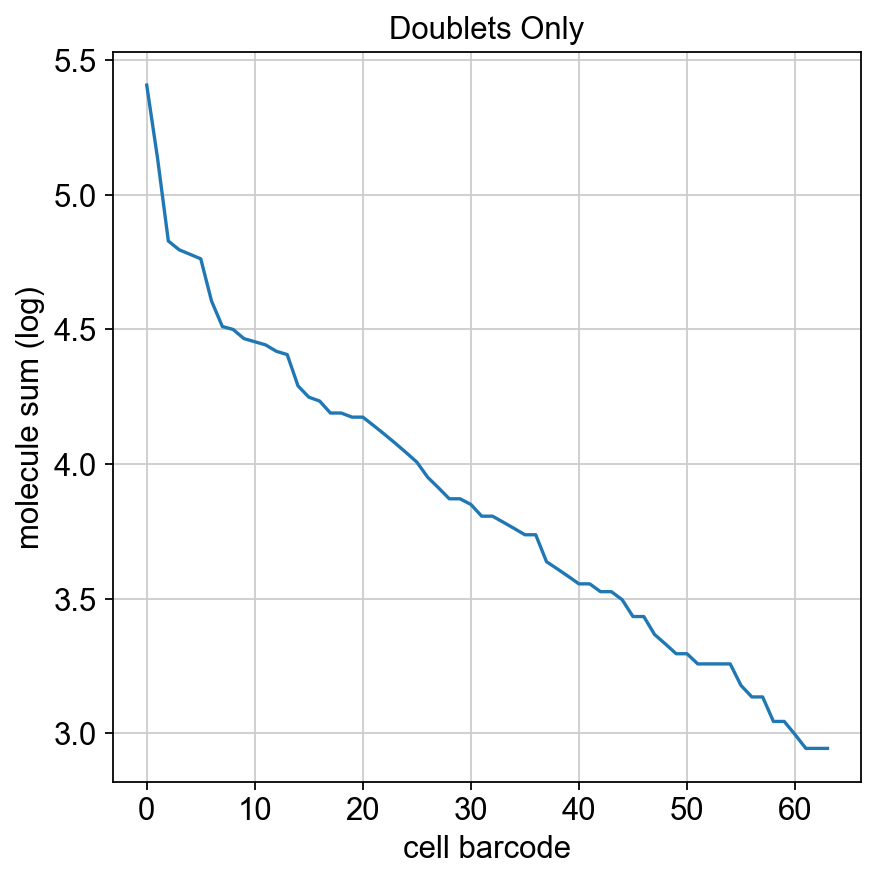

In [129]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

ax.plot(
    range(0, adata_sorted[mask_doublet].shape[0]),
    np.log(adata_sorted[mask_doublet].obs["total_umis"] + 1)
)
ax.set_ylabel("molecule sum (log)")
ax.set_xlabel("cell barcode")
ax.set_title("Doublets Only")

plt.show()

In [130]:
# doublet only, total_umis < 10
adata_sorted[mask_doublet & (adata_sorted.obs["total_umis"] < 10)].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT


In [131]:
# doublet only, total_umis >= 10
adata_sorted[mask_doublet & (adata_sorted.obs["total_umis"] >= 10)].to_df()

,CC0301-ACCCACCAGTAAGAC,C0302-GGTCGAGAGCATTCA,C0303-CTTGCCGCATGTCAT
AGGCCACAGTTCGCGC,0,176,46
GATCGCGGTCTTGTCC,0,139,30
ATTGGACGTCCGTCAG,1,97,26
ATGCGATGTACTTAGC,0,82,38
ACTGCTCTCTCTAGGA,0,98,20
...,...,...,...
GCACATATCCAAAGTC,15,0,5
GACGTTACATTTCACT,9,0,10
ATCCGAAAGAAGGACA,8,0,10
GTGTTAGGTAACGACG,9,0,9


## Max vs. Rest Sum

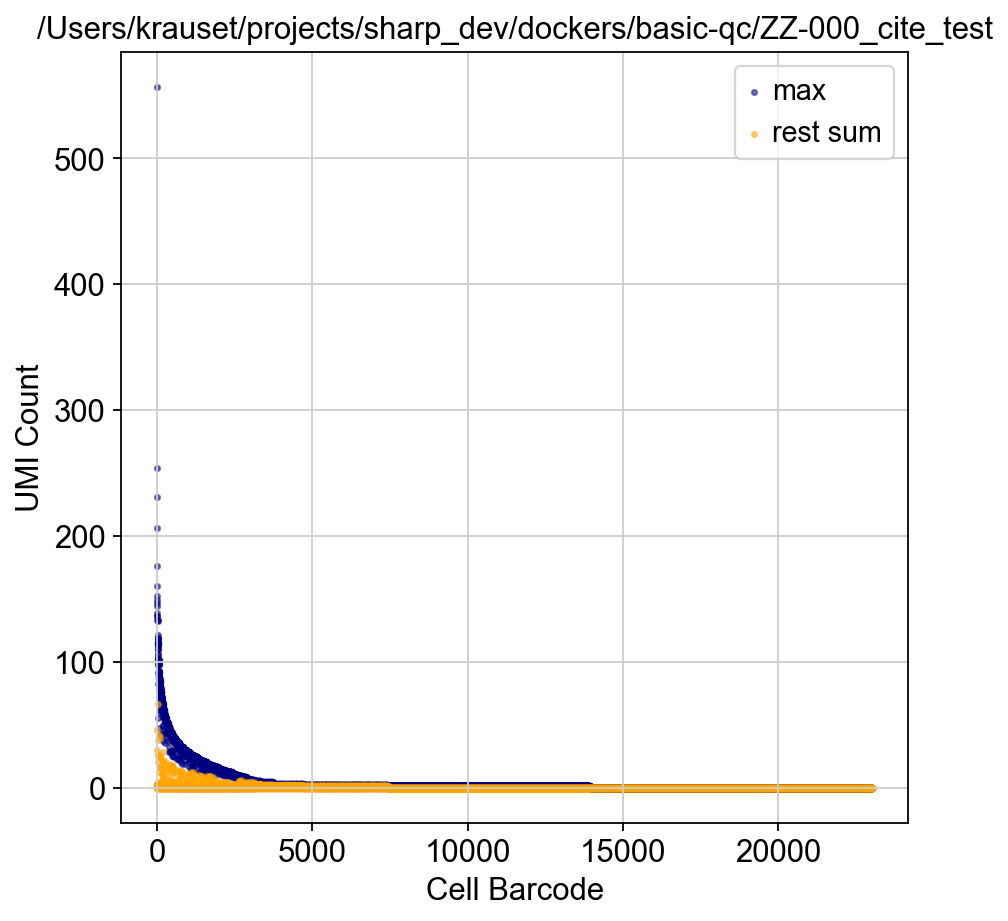

In [132]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")

df_sorted = pd.DataFrame(
    np.vstack(adata_sorted.to_df().apply(
        lambda row: sorted(row, reverse=True), axis=1)
    ),
    index=adata.obs_names
)
dfx = df_sorted.copy()
dfx = dfx.assign(rest=df_sorted.iloc[:, 1:].sum(axis=1))
dfx = dfx.assign(maxx=df_sorted.max(axis=1))

ax.scatter(
    range(len(dfx)),
    dfx.maxx,
    c="navy", s=5, alpha=0.5, label="max"
)
ax.scatter(
    range(len(dfx)), dfx.rest,
    c="orange", s=5, alpha=0.5, label="rest sum"
)
ax.set_xlabel("Cell Barcode")
ax.set_ylabel("UMI Count")
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
ax.legend()
ax.set_title(sample_name)

plt.tight_layout()
plt.show()

## UMAP

In [144]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [145]:
adata.raw = adata

In [146]:
clr_normalize_each_cell(adata)

AnnData object with n_obs × n_vars = 23026 × 3
    obs: 'unmapped', 'barcode_sequence', 'hashID', 'Doublet_Info', 'unmapped_reads', 'total_reads', 'total_umis'
    var: 'feature_name', 'total_reads'
    uns: 'metrics'
    layers: 'dsb_normalized', 'reads'

In [147]:
sc.pp.log1p(adata)

In [148]:
sc.pp.neighbors(adata)

computing neighbors
    using data matrix X directly


/Users/krauset/.pyenv/versions/basicqc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


In [151]:
sc.tl.leiden(adata, resolution=0.05, random_state=42)

running Leiden clustering


/var/folders/cr/tgfzhd3x5cq846swrbb6hh25l39xvy/T/ipykernel_79229/202231325.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.05, random_state=42)


    finished: found 88 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [152]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:25)


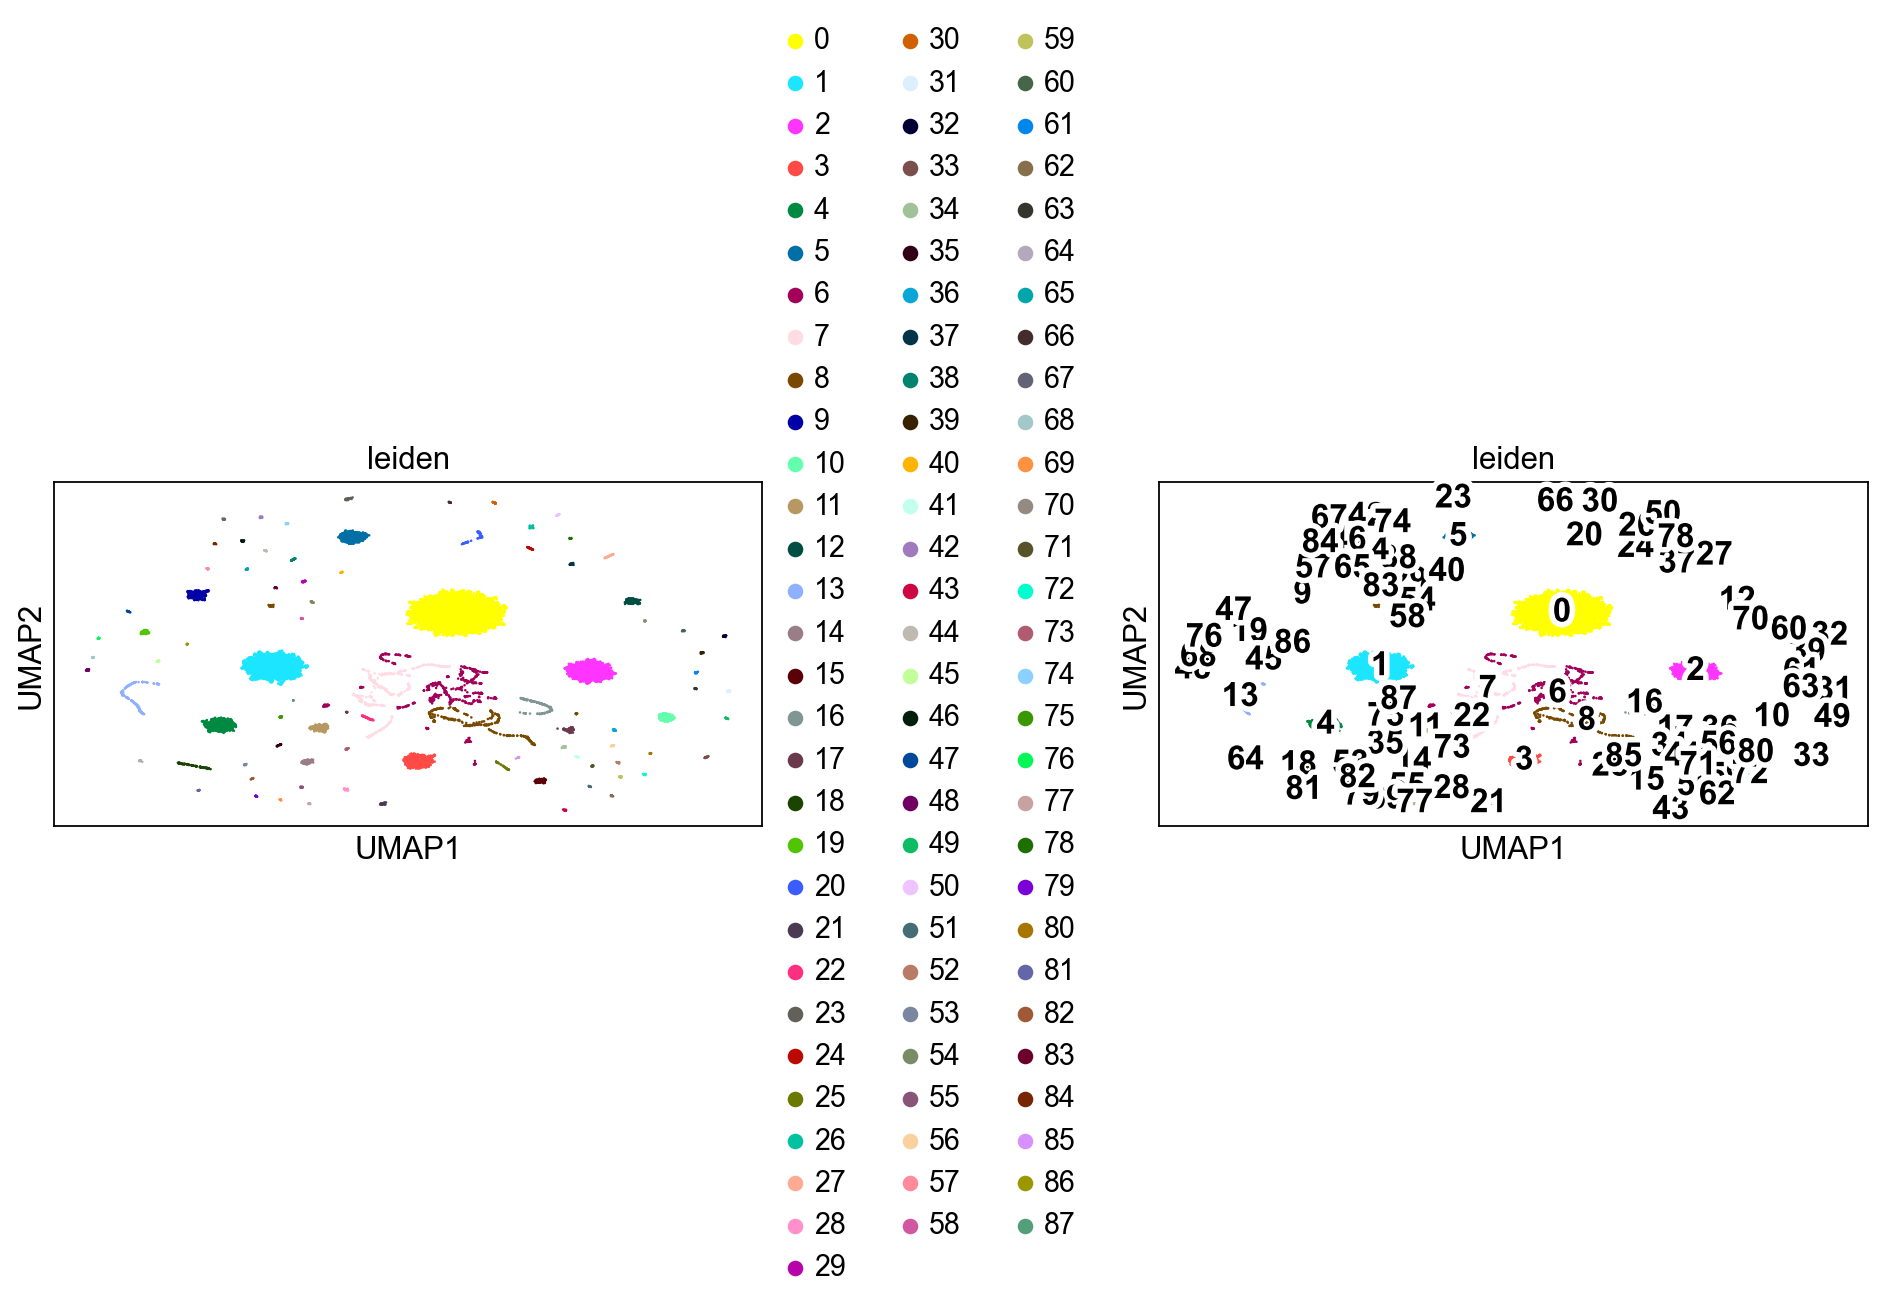

In [154]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata,
    color=["leiden"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata,
    color=["leiden"],
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

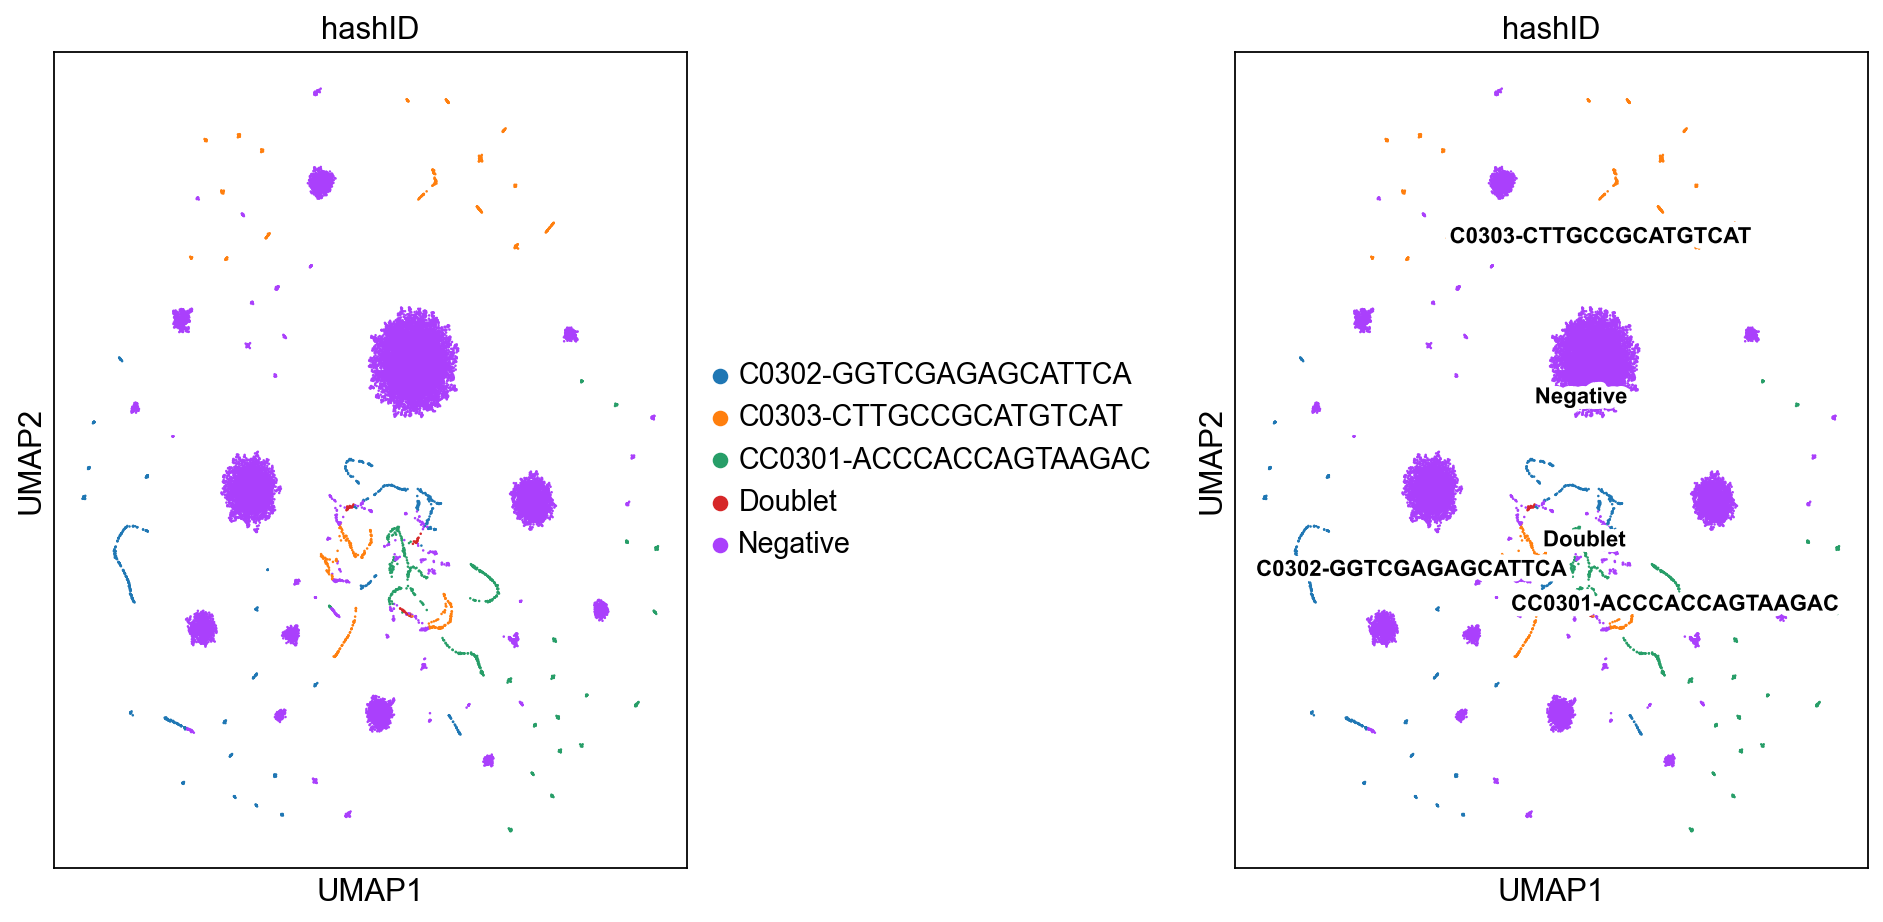

In [156]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sc.pl.umap(
    adata,
    color=["hashID"],
    ax=axs[0], show=False
)

sc.pl.umap(
    adata,
    color=["hashID"],
    legend_loc="on data",
    legend_fontsize=10,
    legend_fontoutline=5,
    ax=axs[1], show=False
)

plt.tight_layout()
plt.show()

In [160]:
from matplotlib.colors import ListedColormap

my_cmap1 = ListedColormap(sns.color_palette("Blues").as_hex())
my_cmap2 = sns.color_palette("Paired").as_hex()
my_cmap2[0] = "lightgray"
my_cmap2 = ListedColormap(my_cmap2)

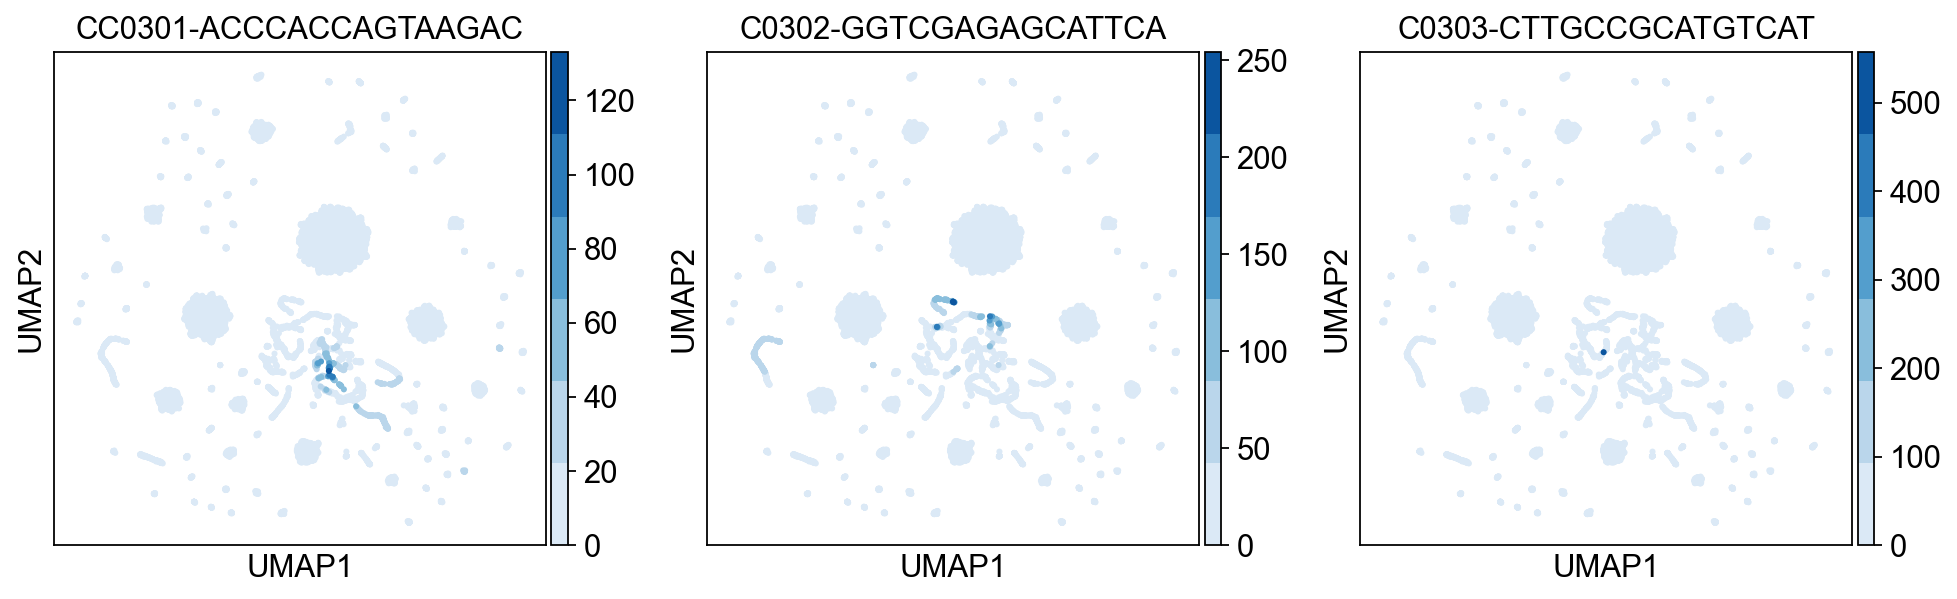

In [161]:
sc.pl.umap(
    adata,
    color=adata.var_names,
    color_map=my_cmap1,
    size=30,
    ncols=3,
)

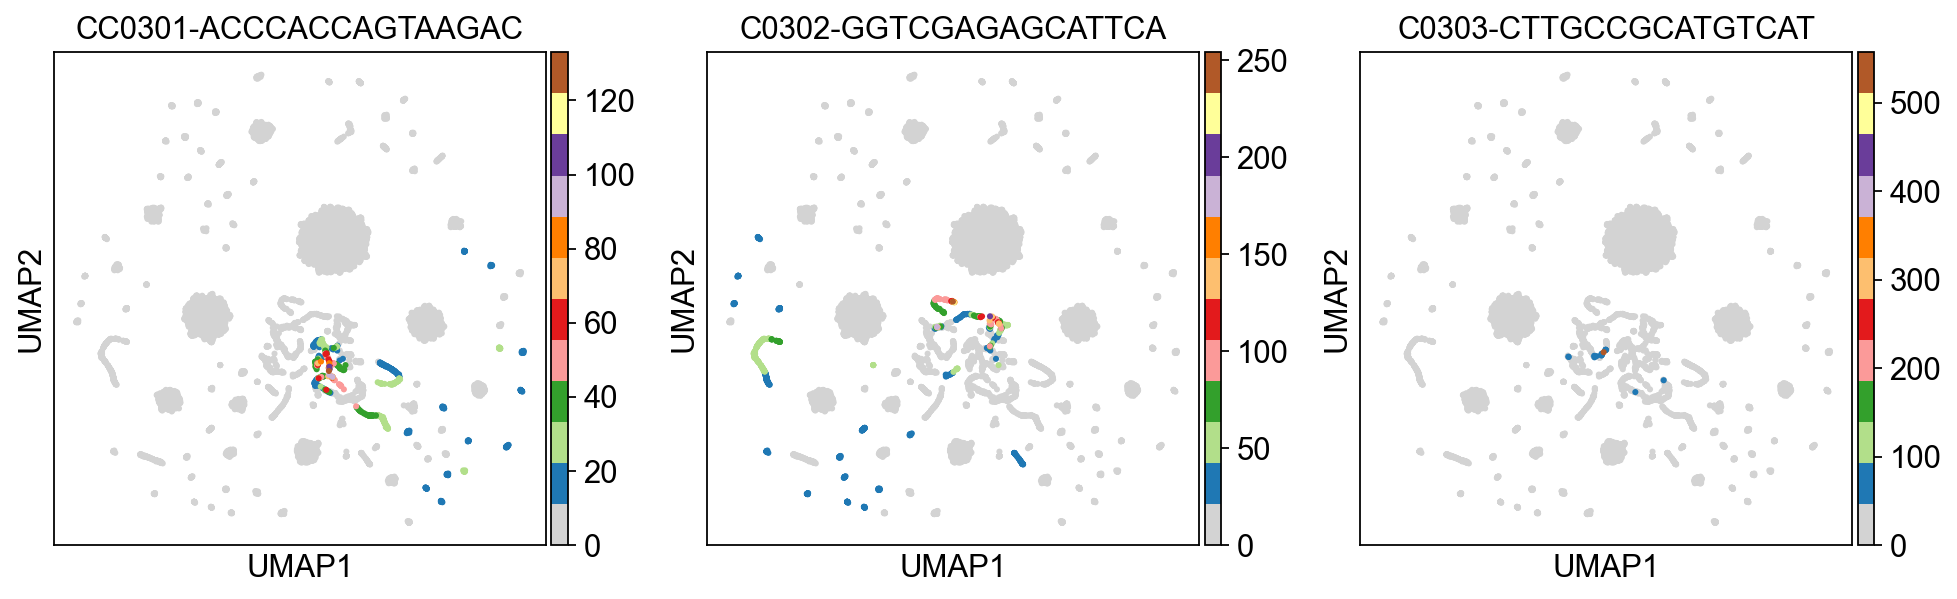

In [162]:
sc.pl.umap(
    adata,
    color=adata.var_names,
    color_map=my_cmap2,
    size=30,
    ncols=3,
)

## Write adata to Disk

In [163]:
adata

AnnData object with n_obs × n_vars = 23026 × 3
    obs: 'unmapped', 'barcode_sequence', 'hashID', 'Doublet_Info', 'unmapped_reads', 'total_reads', 'total_umis', 'leiden'
    var: 'feature_name', 'total_reads'
    uns: 'metrics', 'log1p', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'hashID_colors'
    obsm: 'X_umap'
    layers: 'dsb_normalized', 'reads'
    obsp: 'distances', 'connectivities'

In [164]:
adata.write(os.path.join(path_outdir, f"{sample_name}.QC.h5ad"))